# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import scipy
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import scikitplot.metrics as skplt


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

    
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above statements
from tqdm import tqdm
from bs4 import BeautifulSoup

ps=PorterStemmer()
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = ' '.join(ps.stem(e.lower()) for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:10<00:00, 655.42it/s]


In [17]:
#len(preprocessed_reviews)
preprocessed_reviews[1000]

'yummi easi unusu make quick delic pie crisp cobbler home made better heck lot work great hand last minut dessert need realli want impress wih creativ cook recommend'

In [18]:
final['CleanedText']=preprocessed_reviews
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [19]:
final['Time'][0]

1303862400

In [20]:
#Sorting based on Time
final['Time'] = pd.to_datetime(final['Time'], origin='unix', unit='s')
final = final.sort_values('Time')
print(final.shape)
print(final['Time'].head(1000))

(46071, 11)
1146    2000-06-23
1145    2000-06-29
28086   2003-10-25
28087   2003-10-25
38740   2003-10-31
           ...    
2873    2007-02-14
6560    2007-02-14
30910   2007-02-15
47172   2007-02-15
40986   2007-02-15
Name: Time, Length: 1000, dtype: datetime64[ns]


In [21]:
#Splitting Data into Train CV and Test
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split

X_tr, X_test, Y_tr, Y_test = train_test_split(final['CleanedText'], final['Score'],
                                                    test_size=.33, random_state=0)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_tr, Y_tr, test_size=.33, random_state=0)

In [22]:
print([i.shape for i in [X_train,Y_train, X_cv, Y_cv, X_test, Y_test]])

[(20680,), (20680,), (10187,), (10187,), (15204,), (15204,)]


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


def knn(X_train, Y_train, X_cv, Y_cv, X_test, Y_test, algorithm): 
    pred_cv=[]
    pred_train=[]
    k=[]
    for i in tqdm(range (9, 70, 2)):
         knn=KNeighborsClassifier(n_neighbors=i, algorithm=algorithm, p=2, n_jobs=-1)
         # fitting the model on train
         knn.fit(X_train, Y_train)
         _prob_cv = knn.predict_proba(X_cv)[:,1]
         _prob_train = knn.predict_proba(X_train)[:,1]
         auc_score_cv = roc_auc_score(Y_cv,_prob_cv)
         auc_score_train = roc_auc_score(Y_train,_prob_train)
         pred_cv.append(auc_score_cv)
         pred_train.append(auc_score_train)
         k.append(i)
        
        
    best_hyperparameter=k[pred_cv.index(max(pred_cv))]
    print('Best Hyperparamer K is- ', best_hyperparameter)
    plt.plot(k, pred_cv,'r-', label = 'Validation AUC')
    plt.plot(k,pred_train,'g-', label ='Train AUC')
    plt.legend(loc='upper right')
    plt.title("Hyperparameter K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('Hyper Paramer K')
    plt.show()
    
    return best_hyperparameter


In [24]:
def knn_test(X_train, Y_train, X_test, Y_test, algorithm, best_hyperparameter):
    pred_test=[]
    pred_train=[]
    knn= KNeighborsClassifier(n_neighbors=best_hyperparameter, algorithm=algorithm,p=2, n_jobs=-1)
    knn.fit(X_test, Y_test)
    prob_test=knn.predict_proba(X_test)[:,1]
    prob_train = knn.predict_proba(X_train)[:,1]
    test_fpr, test_tpr, _ = roc_curve(Y_test,prob_test )
    train_fpr, train_tpr, _ = roc_curve(Y_train,prob_train )
    print("AUC Score",roc_auc_score(Y_test,prob_test))

    # plot the roc curve 
    plt.plot(test_fpr, test_tpr, linestyle='--', label='Test ROC')
    plt.plot(train_fpr, train_tpr, marker='.', label='Train ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    #plot confusion matrix 
    skplt.plot_confusion_matrix(Y_test, knn.predict(X_test))


# [4] Featurization using Brute Algorithm

## [4.1] BAG OF WORDS

In [25]:
#Compute BoW
countVector=CountVectorizer(min_df=5)
bow_train=countVector.fit_transform(X_train)

bow_cv=countVector.transform(X_cv)
bow_test=countVector.transform(X_test)

print(list(map(type, [bow_train,bow_cv,bow_test])))
print('Shape of bow_train is: ', bow_train.shape)
print('Shape of bow_cv is: ', bow_cv.shape)
print('Shape of bow_test is: ', bow_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (20680, 5911)
Shape of bow_cv is:  (10187, 5911)
Shape of bow_test is:  (15204, 5911)


In [26]:
#Normalise BoW Data
bow_train=normalize(X=bow_train, axis=1, norm='l2')
bow_cv=normalize(X=bow_cv, axis=1, norm='l2')
bow_test=normalize(X=bow_test,axis=1, norm='l2')


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [23:05<00:00, 44.68s/it]


Best Hyperparamer K is-  69


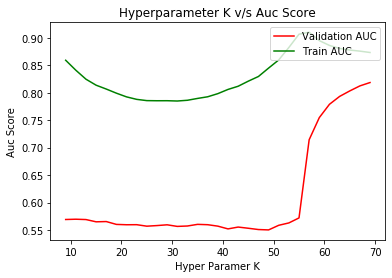

In [27]:
#map(scipy.sparse.csr.csr_matrix.toarray, [bow_train, bow_cv, bow_test])
best_hyperparameter= knn(bow_train,Y_train, bow_cv,Y_cv, bow_test, Y_test,  'brute')


ROC Curve for Best Hyper parameter K:  69
AUC Score 0.8599941894719277


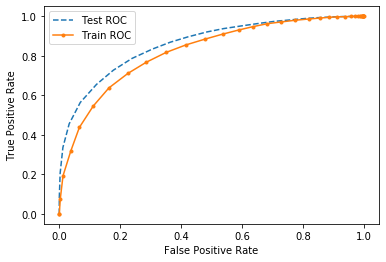

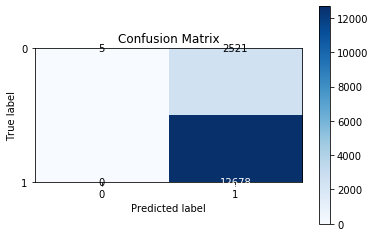

In [28]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(bow_train,Y_train,  bow_test, Y_test,  'brute',  best_hyperparameter)

## [4.2] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_train=tf_idf_vect.fit_transform(X_train)

tf_idf_cv = tf_idf_vect.transform(X_cv)
tf_idf_test=tf_idf_vect.transform(X_test)


print(list(map(type, [tf_idf_train,tf_idf_cv,tf_idf_test])))
print('Shape of bow_train is: ', tf_idf_train.shape)
print('Shape of bow_cv is: ', tf_idf_cv.shape)
print('Shape of bow_test is: ', tf_idf_test.shape)


[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (20680, 28452)
Shape of bow_cv is:  (10187, 28452)
Shape of bow_test is:  (15204, 28452)


In [30]:
#normalize
tf_idf_train=normalize(tf_idf_train)
tf_idf_cv = normalize(tf_idf_cv)
tf_idf_test=normalize(tf_idf_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [24:04<00:00, 46.60s/it]


Best Hyperparamer K is-  69


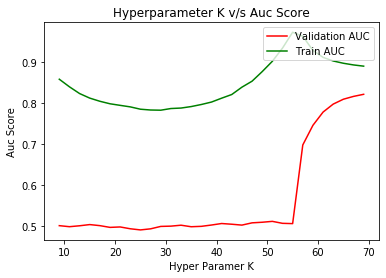

In [31]:
best_hyperparameter= knn(tf_idf_train,Y_train, tf_idf_cv,Y_cv, tf_idf_test, Y_test,  'brute')


ROC Curve for Best Hyper parameter K:  69
AUC Score 0.8815858688506859


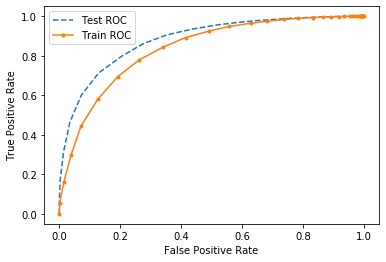

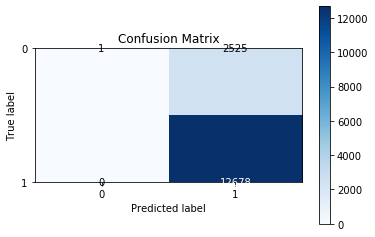

In [32]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(tf_idf_train,Y_train,  tf_idf_test, Y_test,  'brute',  best_hyperparameter)

## [4.3] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

### [4.3.1] Avg W2v

In [33]:
# average Word2Vec for train, validation and test data 
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#avgw2v for train data
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#avgw2v for validation data
list_of_sentance_cv=[]
sent_vectors_cv = []
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

#avgw2v for test data
sent_vectors_test = []
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))



100%|███████████████████████████████████████████████████████████████████████████| 20680/20680 [00:30<00:00, 674.25it/s]


20680
50


100%|███████████████████████████████████████████████████████████████████████████| 10187/10187 [00:15<00:00, 675.14it/s]


10187
50


100%|███████████████████████████████████████████████████████████████████████████| 15204/15204 [00:22<00:00, 675.31it/s]


15204
50


In [34]:
#Normalizing
avgw2v_train=normalize(sent_vectors_train)
avgw2v_cv=normalize(sent_vectors_cv)
avgw2v_test=normalize(sent_vectors_test)


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [20:14<00:00, 39.18s/it]


Best Hyperparamer K is-  67


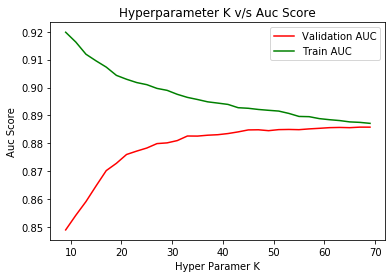

In [35]:
best_hyperparameter= knn(avgw2v_train,Y_train, avgw2v_cv,Y_cv, avgw2v_test, Y_test,  'brute')


ROC Curve for Best Hyper parameter K:  67
AUC Score 0.8824298130801083


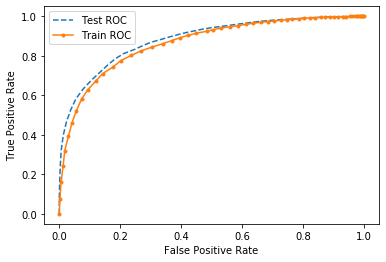

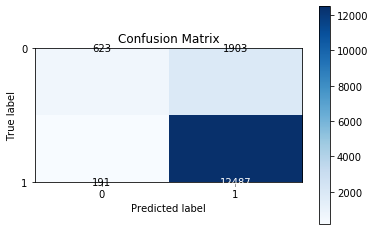

In [36]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(avgw2v_train,Y_train,  avgw2v_test, Y_test,  'brute',  best_hyperparameter)

### [4.3.2] TFIDF weighted W2V

In [37]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#TFIDF weighted W2V for train data
tfidf_sent_vectors_train = []
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#TFIDF weighted W2V for validation data
list_of_sentance_cv=[]
tfidf_sent_vectors_cv = []

for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1    
#TFIDF weighted W2V for test data

list_of_sentance_test=[]
tfidf_sent_vectors_test = []
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 15204/15204 [00:32<00:00, 463.61it/s]


In [38]:
#normalize train, validation and test data
tfidf_w2v_train=normalize(tfidf_sent_vectors_train)
tfidf_w2v_cv=normalize(tfidf_sent_vectors_cv)
tfidf_w2v_test=normalize(tfidf_sent_vectors_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [20:10<00:00, 39.06s/it]


Best Hyperparamer K is-  63


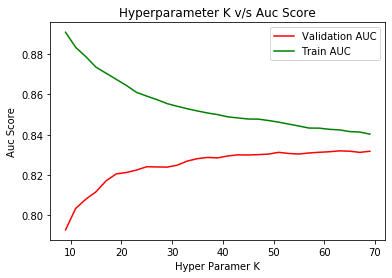

In [39]:
best_hyperparameter= knn(tfidf_w2v_train,Y_train, tfidf_w2v_cv,Y_cv, tfidf_w2v_test, Y_test,  'brute')


ROC Curve for Best Hyper parameter K:  63
AUC Score 0.8825635538998298


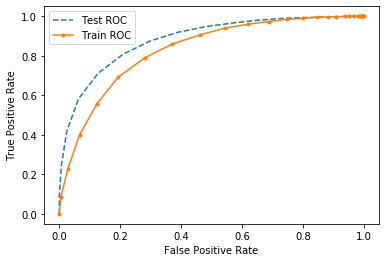

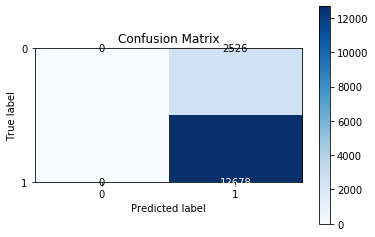

In [40]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(tf_idf_train,Y_train,  tf_idf_test, Y_test,  'brute',  best_hyperparameter)

# [5] Featurization using kd-tree Algorithm

## [5.1] Bag Of Words

In [41]:
#Compute BoW
countVector=CountVectorizer(min_df=5, max_features=500)
bow_train=countVector.fit_transform(X_train)

bow_cv=countVector.transform(X_cv)
bow_test=countVector.transform(X_test)

print(list(map(type, [bow_train,bow_cv,bow_test])))
print('Shape of bow_train is: ', bow_train.shape)
print('Shape of bow_cv is: ', bow_cv.shape)
print('Shape of bow_test is: ', bow_test.shape)

[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (20680, 500)
Shape of bow_cv is:  (10187, 500)
Shape of bow_test is:  (15204, 500)


In [42]:
#Normalise BoW Data
bow_train=normalize(X=bow_train, axis=1, norm='l2')
bow_cv=normalize(X=bow_cv, axis=1, norm='l2')
bow_test=normalize(X=bow_test,axis=1, norm='l2')

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [18:03<00:00, 34.95s/it]


Best Hyperparamer K is-  69


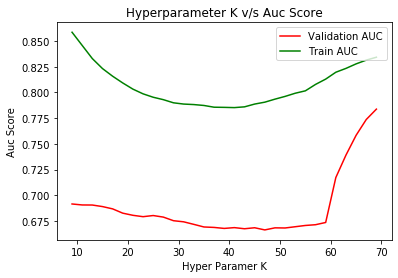

In [43]:
#convert sparse matrix to dense and find best k
map(scipy.sparse.csr.csr_matrix.toarray, [bow_train, bow_cv, bow_test])
best_hyperparameter= knn(bow_train,Y_train, bow_cv,Y_cv, bow_test, Y_test,  'kd_tree')


ROC Curve for Best Hyper parameter K:  69
AUC Score 0.8460979312546582


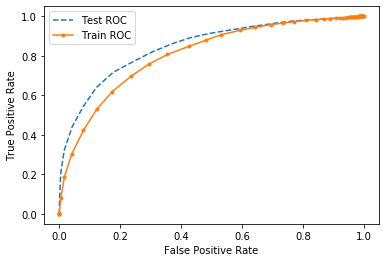

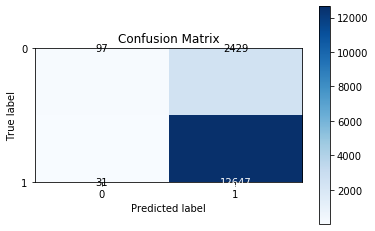

In [44]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(bow_train,Y_train,  bow_test, Y_test,  'kd_tree',  best_hyperparameter)

## [5.2] TF_IDF

In [45]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=500)
tf_idf_train=tf_idf_vect.fit_transform(X_train)

tf_idf_cv = tf_idf_vect.transform(X_cv)
tf_idf_test=tf_idf_vect.transform(X_test)


print(list(map(type, [tf_idf_train,tf_idf_cv,tf_idf_test])))
print('Shape of bow_train is: ', tf_idf_train.shape)
print('Shape of bow_cv is: ', tf_idf_cv.shape)
print('Shape of bow_test is: ', tf_idf_test.shape)

[<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>]
Shape of bow_train is:  (20680, 500)
Shape of bow_cv is:  (10187, 500)
Shape of bow_test is:  (15204, 500)


In [46]:
tf_idf_train=normalize(tf_idf_train)
tf_idf_cv = normalize(tf_idf_cv)
tf_idf_test=normalize(tf_idf_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [17:48<00:00, 34.47s/it]


Best Hyperparamer K is-  69


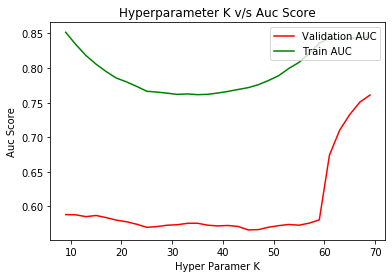

In [47]:
map(scipy.sparse.csr.csr_matrix.toarray, [tf_idf_train, tf_idf_cv, tf_idf_test])
best_hyperparameter= knn(tf_idf_train,Y_train, tf_idf_cv,Y_cv, tf_idf_test, Y_test,  'kd_tree')


ROC Curve for Best Hyper parameter K:  69
AUC Score 0.8427393130062276


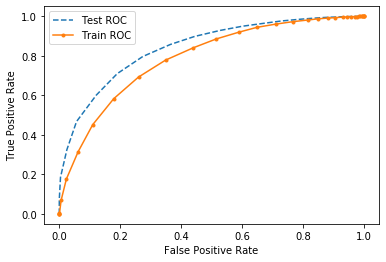

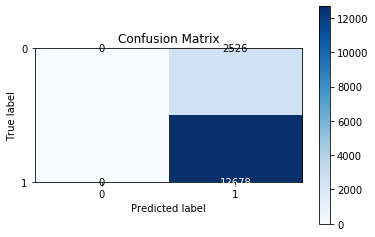

In [48]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(tf_idf_train,Y_train,  tf_idf_test, Y_test,  'kd_tree',  best_hyperparameter)

## [5.3] Word2Vec 


###  [5.3.1] Avg W2v

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [19:12<00:00, 37.17s/it]


Best Hyperparamer K is-  67


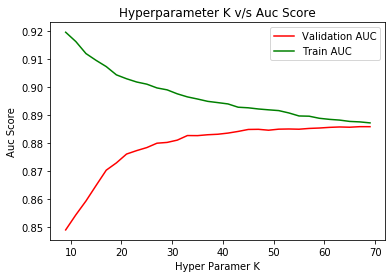

In [49]:
best_hyperparameter= knn(avgw2v_train,Y_train, avgw2v_cv,Y_cv, avgw2v_test, Y_test,  'kd_tree')


ROC Curve for Best Hyper parameter K:  67
AUC Score 0.8825657397175699


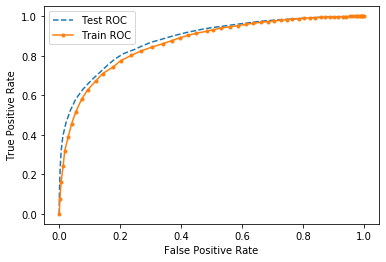

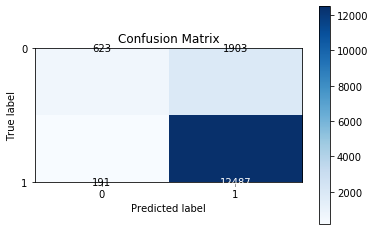

In [50]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(avgw2v_train,Y_train,  avgw2v_test, Y_test,  'kd_tree',  best_hyperparameter)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [18:54<00:00, 36.59s/it]


Best Hyperparamer K is-  69


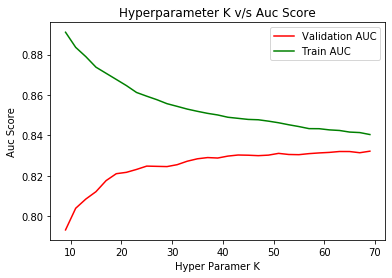

In [51]:
best_hyperparameter= knn(tfidf_w2v_train,Y_train, tfidf_w2v_cv,Y_cv, tfidf_w2v_test, Y_test,  'kd_tree')

### [5.3.2] TFIDF weighted W2V


ROC Curve for Best Hyper parameter K:  69
AUC Score 0.8460979312546582


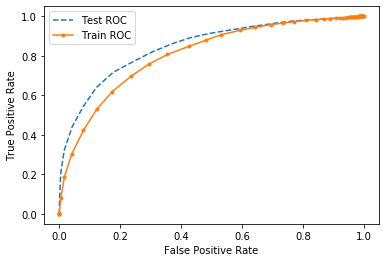

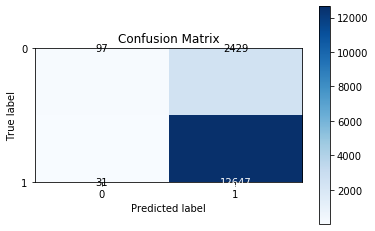

In [53]:
print('\nROC Curve for Best Hyper parameter K: ', best_hyperparameter)
knn_test(bow_train,Y_train,  bow_test, Y_test,  'kd_tree',  best_hyperparameter)

In [55]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best hyper parameter(K)","Test AUC Score"]

x.add_row(["BoW","Brute",69,0.859994])
x.add_row(["tf-idf","Brute",69,0.881585])
x.add_row(["avg Word2Vec","Brute",67,0.882429])
x.add_row(["tf-idf word2vec","Brute",63,0.882563])
x.add_row(["BoW","kd-Tree",69,0.846097])
x.add_row(["tf-idf","kd-Tree",69,0.842739])
x.add_row(["avg Word2Vec","kd-Tree",67,0.882565])
x.add_row(["tf-idf word2vec","kd-Tree",69,0.846097])

print(x)

+-----------------+---------+-------------------------+----------------+
|    Vectorizer   |  Model  | Best hyper parameter(K) | Test AUC Score |
+-----------------+---------+-------------------------+----------------+
|       BoW       |  Brute  |            69           |    0.859994    |
|      tf-idf     |  Brute  |            69           |    0.881585    |
|   avg Word2Vec  |  Brute  |            67           |    0.882429    |
| tf-idf word2vec |  Brute  |            63           |    0.882563    |
|       BoW       | kd-Tree |            69           |    0.846097    |
|      tf-idf     | kd-Tree |            69           |    0.842739    |
|   avg Word2Vec  | kd-Tree |            67           |    0.882565    |
| tf-idf word2vec | kd-Tree |            69           |    0.846097    |
+-----------------+---------+-------------------------+----------------+


## Conclusion:<br>
- We see that Brute alogorithm worked well on tf-idf, avg Word2Vec and tf-idf word2vec with AUC score of about 0.88 <br>
- Also, kd-tree version of vectorizers avg Word2Vec and tf-idf word2vec yield about 0.88 AUC score